In [8]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.metrics import mean_squared_error # type: ignore
from tensorflow.keras import Sequential, Input # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pickle # type: ignore

In [2]:
def load_and_prepare_data(filepath, country_name, window_size=5):
    # Load Excel
    df = pd.read_excel(filepath)

    # Set the index to country names
    df.set_index(df.columns[0], inplace=True)

    # Extract the row for selected country with explicit type handling
    country_series = df.loc[country_name].replace('no data', np.nan)
    country_series = country_series.infer_objects(copy=False).astype(float).dropna()



    # Convert to DataFrame
    data = pd.DataFrame({'Year': country_series.index.astype(int), 'GDP_Growth': country_series.values})

    # Normalize
    scaler = MinMaxScaler()
    data['Normalized'] = scaler.fit_transform(data[['GDP_Growth']])

    # Create sequences
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data['Normalized'].values[i:i + window_size])
        y.append(data['Normalized'].values[i + window_size])
    X, y = np.array(X), np.array(y)

    # Train-test split (50-50)
    split_index = len(X) // 2
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test, scaler, data

In [3]:
def build_and_train_model(X_train, y_train, window_size=5):
    model = Sequential([Input(shape=(window_size, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=200, verbose=0)
    return model

In [4]:
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_pred, scaler, country_name):
    # Inverse transform
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred).flatten()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Actual GDP Growth', marker='o')
    plt.plot(y_pred_inv, label='Predicted GDP Growth', marker='x')
    plt.title(f'{country_name} - GDP Growth Forecast')
    plt.xlabel('Time Index (Years in Test Set)')
    plt.ylabel('GDP Growth (%)')
    plt.legend()
    plt.grid(True)
    plt.ylim(-10, 15)  # Fixed y-axis range; adjust if needed
    plt.tight_layout()
    plt.show()

In [5]:
file_path = "GDP Growth.xlsx"
window_size = 5
results = []

# Step 1: Get list of all countries (one-time read)
df_temp = pd.read_excel(file_path)
df_temp.set_index(df_temp.columns[0], inplace=True)
all_countries = df_temp.index.tolist()
all_countries = [country for country in df_temp.index if isinstance(country, str) and country.lower() != 'nan']

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.metrics import mean_squared_error

# Step 2: Parallel execution for each country
def process_country(country):
    try:
        # Load & preprocess
        X_train, X_test, y_train, y_test, scaler, data = load_and_prepare_data(file_path, country, window_size)

        # Train model
        model = build_and_train_model(X_train, y_train, window_size)

        # Predict
        y_pred = model.predict(X_test)

        # Evaluate
        mse = mean_squared_error(
            scaler.inverse_transform(y_test.reshape(-1, 1)),
            scaler.inverse_transform(y_pred)
        )

        return (country, mse, y_test, y_pred, scaler)

    except Exception as e:
        print(f"⚠️ Skipping {country} due to error: {e}")
        return None

# Threaded execution using up to 20 workers
with ThreadPoolExecutor(max_workers=22) as executor:
    futures = [executor.submit(process_country, country) for country in all_countries]
    for future in as_completed(futures):
        result = future.result()
        if result:
            results.append(result)


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)
C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)
C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)
C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)
C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)
C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


C:\Users\ABHIJEET\AppData\Local\Temp\ipykernel_42112\3952107239.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  country_series = df.loc[country_name].replace('no data', np.nan)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


In [9]:
# Save results
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)


 Egypt | MSE: 1.4055


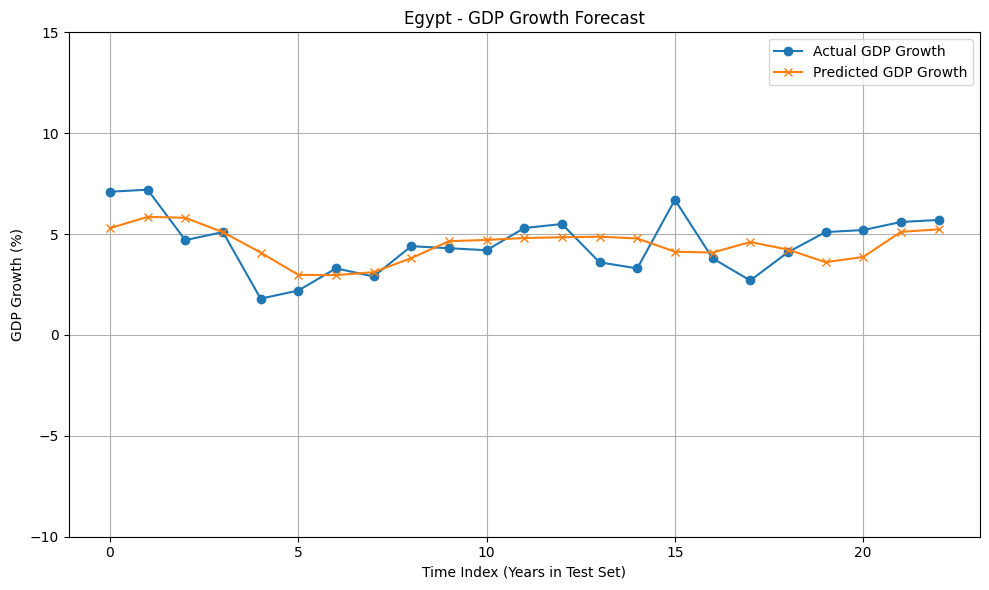


 Somalia | MSE: 1.5124


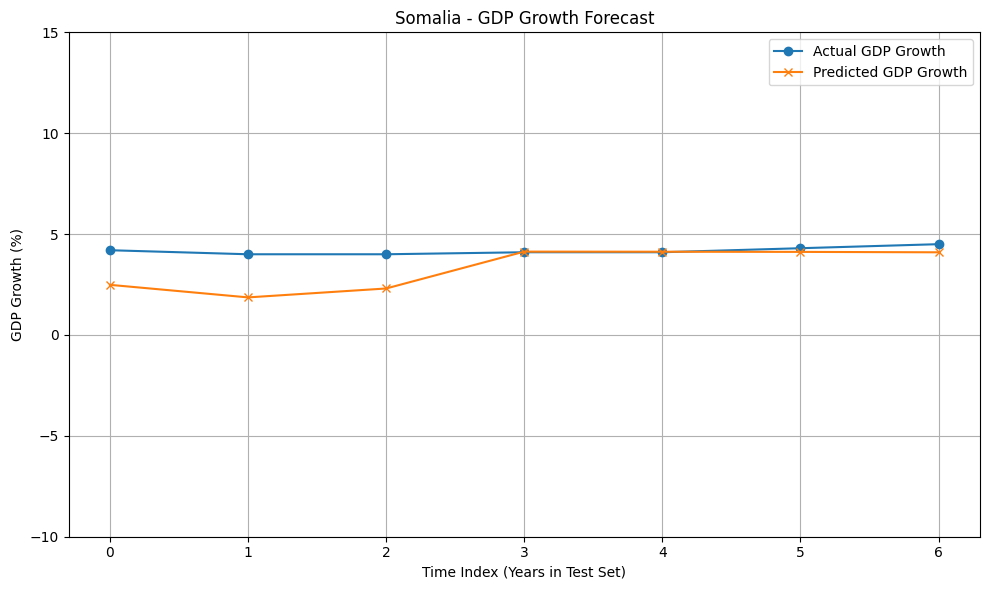

In [11]:
# Step 3: Sort and plot top 2 countries
top_countries = sorted(results, key=lambda x: x[1])[:2]

for country, mse, y_test, y_pred, scaler in top_countries:
    print(f"\n {country} | MSE: {mse:.4f}")
    plot_predictions(y_test, y_pred, scaler, country)


 Libya | MSE: 648.2586


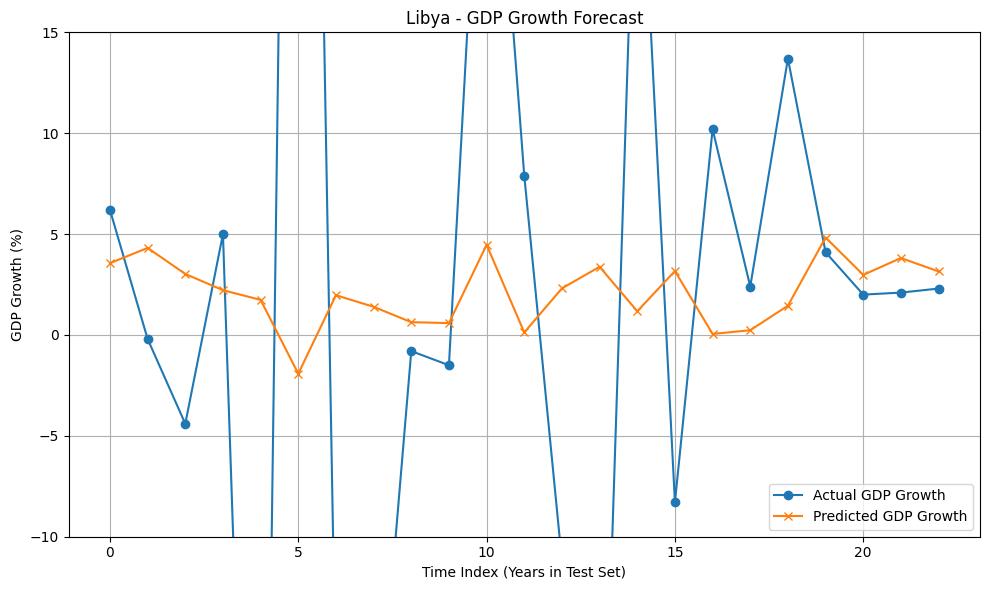


 Macao SAR | MSE: 973.1826


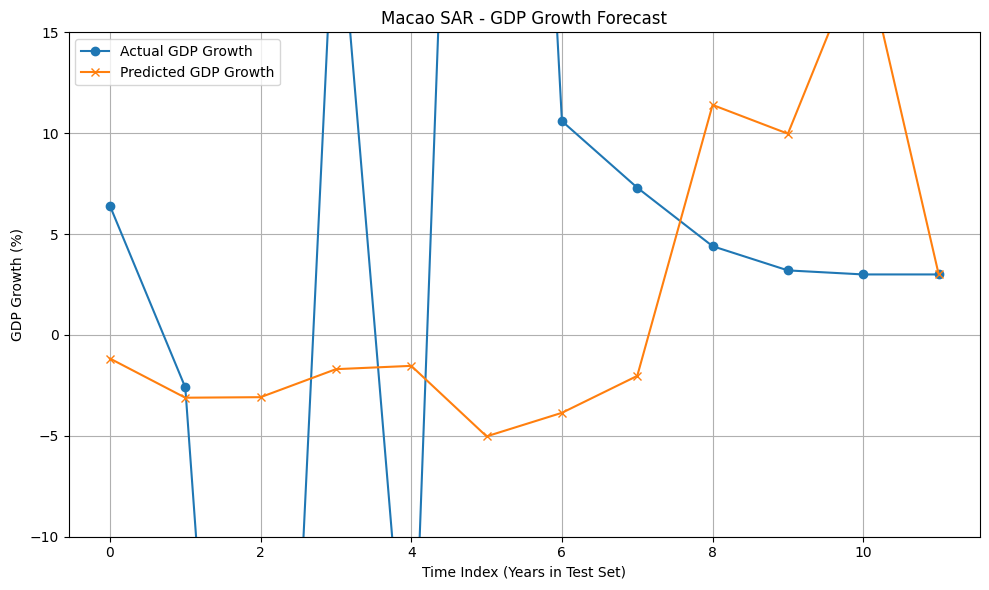

In [14]:
# Step 3: Sort and plot top 2 countries
top_countries = sorted(results, key=lambda x: x[1])[-2:]

for country, mse, y_test, y_pred, scaler in top_countries:
    print(f"\n {country} | MSE: {mse:.4f}")
    plot_predictions(y_test, y_pred, scaler, country)